# An Analysis Site Design's Impact on RateBeer.com Review Contributions
#### jhh283, sjh293

## Abstract
Preece and Schneiderman's Reader-to-Leader Framework (RTLF) [1] details a number of usability and sociability factors that sites can deploy to help promote contributions of user generated content (UGC). In particular, the paper describes "visibility for...contributions" as a motivating factor for ongoing contributions of UGC, along with a "recognition of quality and quantity of contributions." Beenen et al. (2004) [2], building on Karau and William's Collective Effort Model [3], also demonstrated that highlighting the "uniqueness" of contributions on the MovieLens review site was correleated with an increase in UGC on the site. 

This notebook's analysis focuses on RateBeer.com, one of the leading beer review websites, and in particular on a major overhaul of the site's user profile pages in May 2009. RateBeer's 2009 profile page redesign made numerous substantial improvements in line with recommendations offered in the RTLF paper. While the total number of reviews contributed by a user were long included on review pages, in forums posts, and on profile pages, the redesign went to great lengths to expose additional layers of detail about each user's contributions, better highlighting the uniqueness, completeness, and quality of each user's corpus of beer reviews.

Based on the findings in the Preece and Schneiderman's RTLF, we hypothesized that a substantial site redesign which incorporated Preece and Schneiderman's recommendations would result in a measureable increase in the quantity and diversity of UGC. More specifically, the increased visibility on profile pages after May 2009 of a user's beer review variants, the introduction of an activity stream, and clearer presentation of a user's contributions, all in line with RTLF recommendations, would result in a corresponding increase in contributions within at most a year after the launch date.

[1]: Preece, Jennifer and Ben Shneiderman (2009). “The Reader-to-Leader Framework: Motivating Technology-Mediated Social Participation,” in Transactions on Human-Computer Interaction.

[2]: Breece et al (2004). "Using Social Psychology to Motivate Contributions to Online Communities." Paper presented at Computer-Supported Cooperative Work and Social Computing (CSCW) November 6-10, 2004, Chicago, Illinois, USA

[3]: Karau, S. and K. Williams, Social loafing: A meta-analytic review and theoretical integration. Journal of Personality and Social Psychology, 1993. 65(4): p. 681-706.

#### Notebook helper functions and imports

In [2]:
import os

from IPython.display import HTML
from IPython.display import display, Image
from PIL import Image as PILImage

def files_at_relpath(rel_path):
    return [os.path.join(rel_path, f) for f in os.listdir(rel_path)]


def display_images(img_path, **kwargs):
    scale = kwargs.get('scale')
    if scale is not None:
        kwargs.pop('scale', None)
    kwargs.pop("key", None)
    files = files_at_relpath(img_path)
    for filename in files:
        try:
            if scale is None:
                display(Image(filename=filename, **kwargs))
            else:
                w, h = None, None
                with PILImage.open(filename) as imgfile:
                    w, h = imgfile.size
                kwargs['width'] = float(w) * scale
                kwargs['height'] = float(h) * scale
                display(Image(filename=filename, **kwargs))
        except ValueError as e:
            continue

## Introduction


## RateBeer.com 2009 User Profile Redesign
In an effort to confirm our hypothesis, we identified RateBeer redesigns that adhered to the RTLF principles. To pinpoint these redesigns, and to allow for a comparison of the site before and after the redesign, we scanned page archives captured by the Way Back Machine service (archive.org). We quickly realized that many site redesigns were incremental, and that large, site wide redesigns were comparatively rare occerence. One particular redesign did stick out, however, and that was the update to user profile pages launched by RateBeer administrators beginning on May 3, 2009 (forum posts from that time suggest the feature was rolled out of a period of a few weeks)[4].

[4] "Love the New Format on the Userpage..." RateBeer.com, 3 May 2009. Web. 28 Apr. 2015. <http://www.ratebeer.com/forums/love-the-new-format-on-the-userpage_115257.htm>.

### RateBeer.com Profile Pages
* April 2009 profile page (user MiP): https://web.archive.org/web/20090425001049/http://www.ratebeer.com/View-User-10185.htm
* August 2009 profile page (user MiP): https://web.archive.org/web/20090822202711/http://www.ratebeer.com/View-User-10185.htm

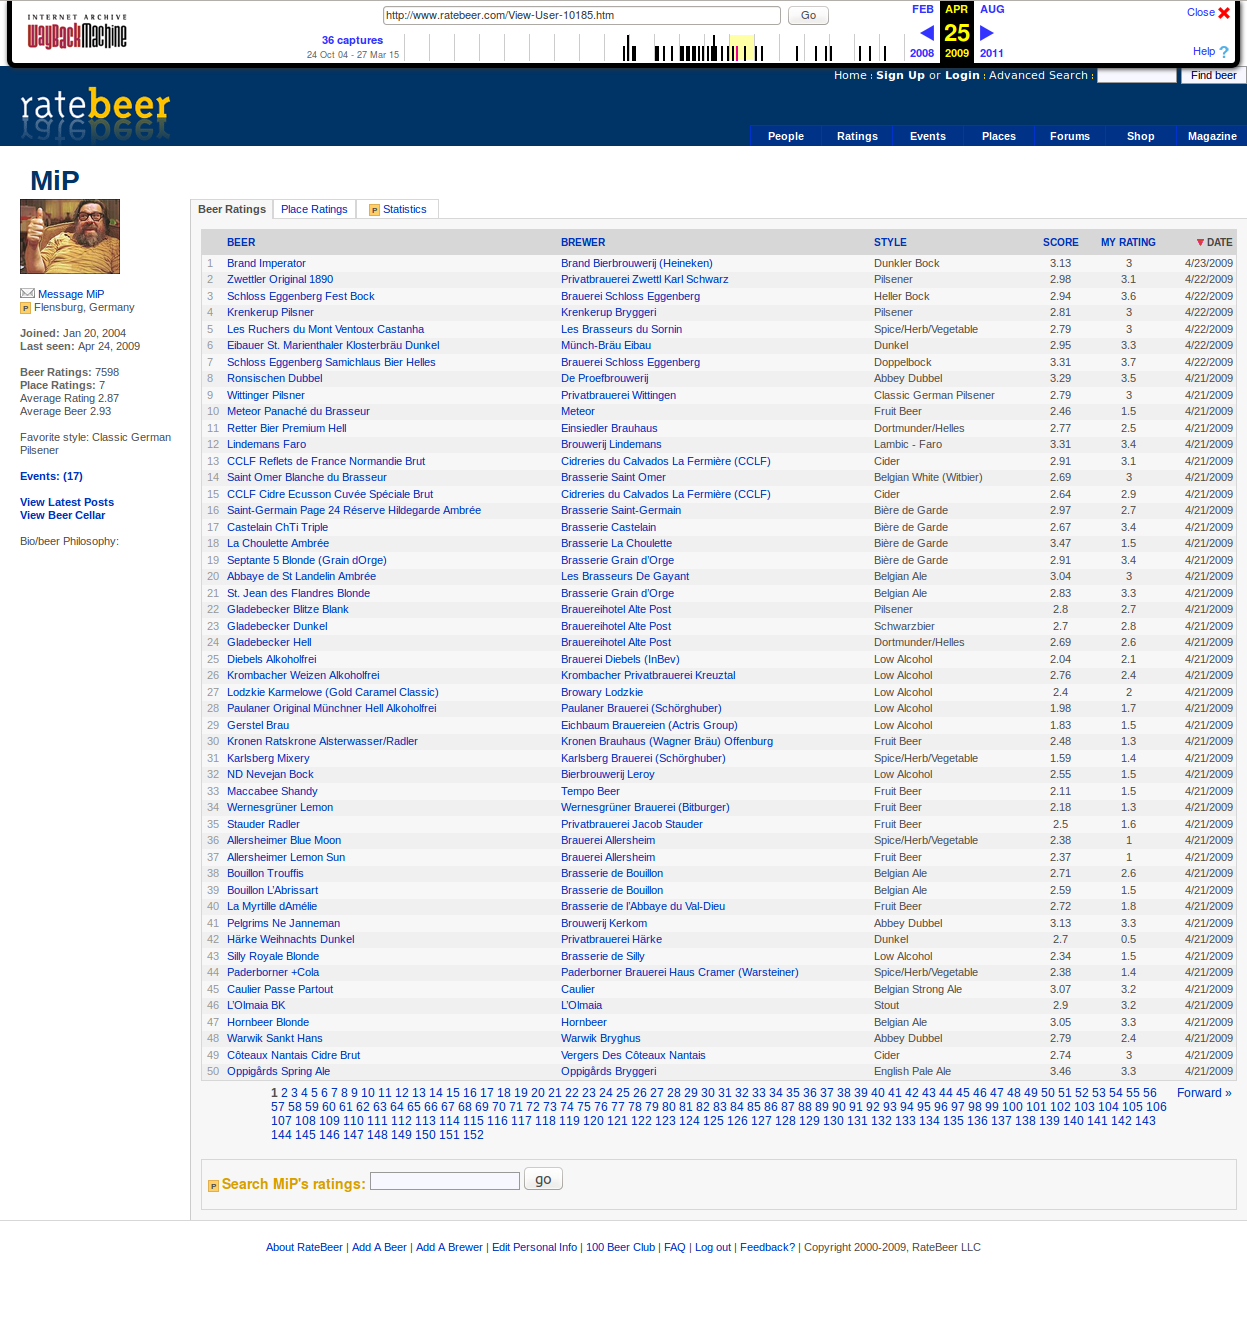

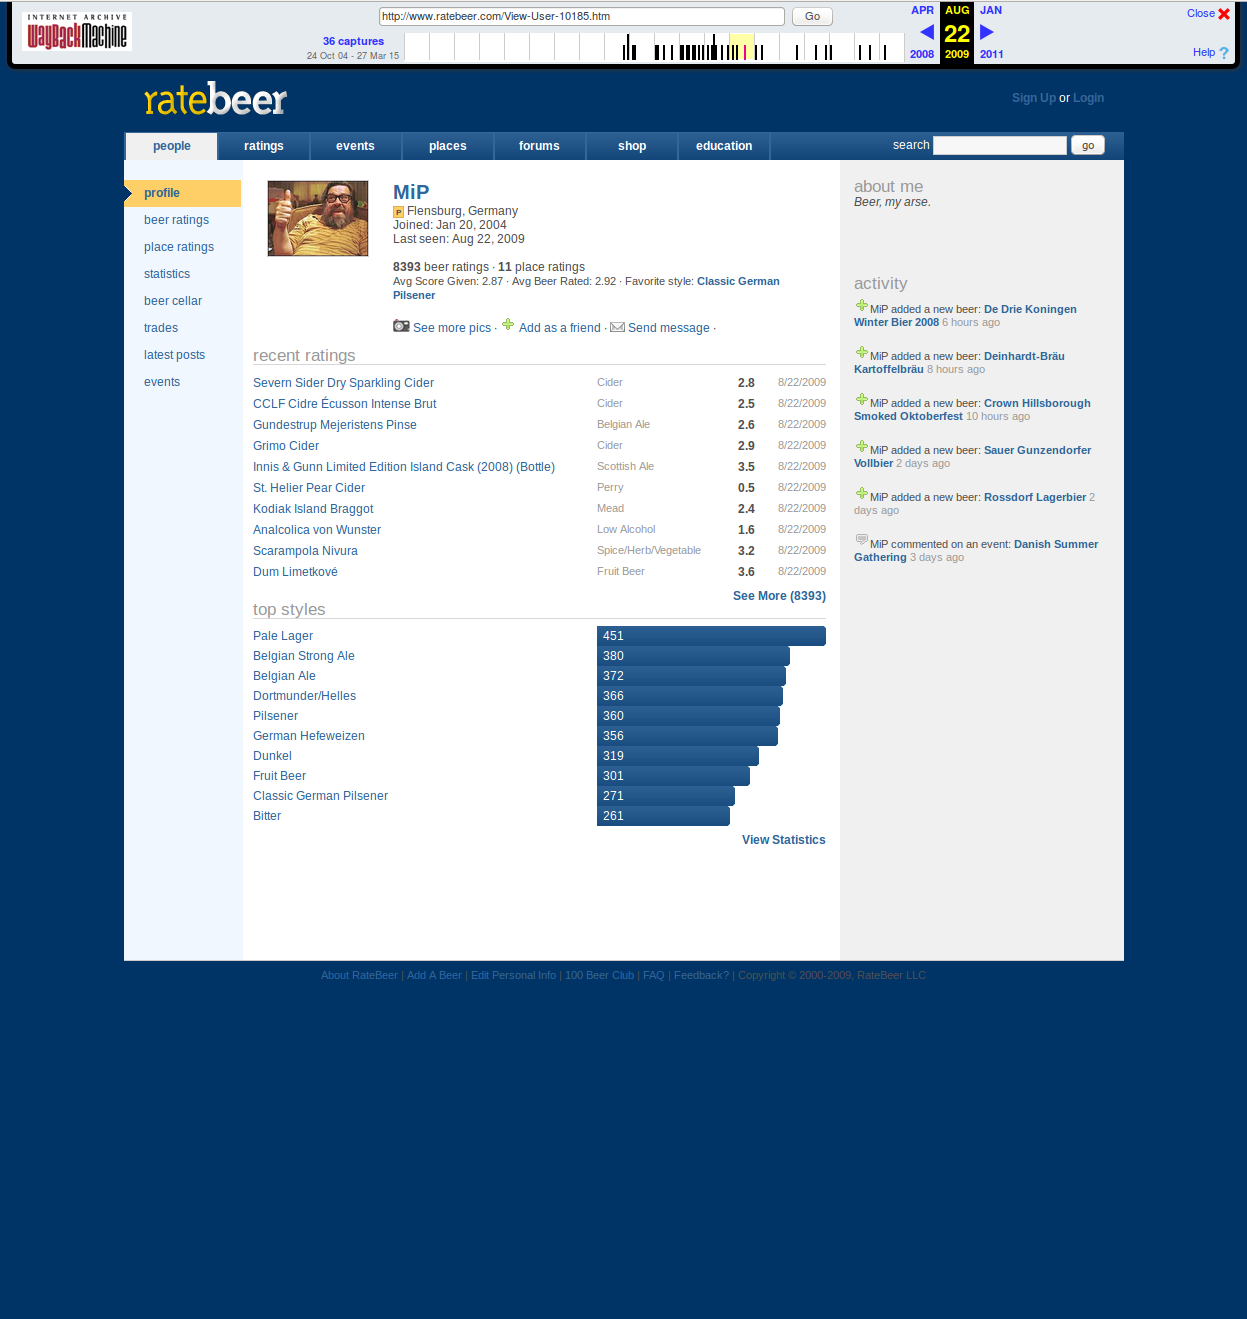

In [4]:
display_images('images/ratebeer/profiles-MiP/', scale=0.7)

### Activity Stream and Top Styles
These two screen captures above show a heavy user's profile as it appeared on April (figure 1, above) and August of 2009 (figure 2, above). Aside from the aesthetic changes, several key changes stand out. Most notable is the introduction of a new "activity" stream (figure 3, below). This feature is a sort of automated social awareness stream of an individual's UGC across the site, likely inspired by the success of Facebook around this time. Furthermore, while statistics were previously available behind the "Statistics" tab on the old site, RateBeer replaced the simple reverse chronological listing of reviews with an interesting summary of the user's  contributions by beer style. This beer style chart, standing clearly out on its white background, also draws attention to a more prominent link to the full page of statistics.

In their MovieLens study, Breece et al. explain that "the collective effort model posits that people will socially loaf less when they perceive that their contribution is important to the group...if they think they are unique, they should be more motivated to contribute." [3] The top styles chart in particular, and the increased emphasis on each user's contribution characteristics over the plain listing of reviews more generally, appears to be designed to better represent the uniqueness of each contributor. These features allow "contributors to stand out," a

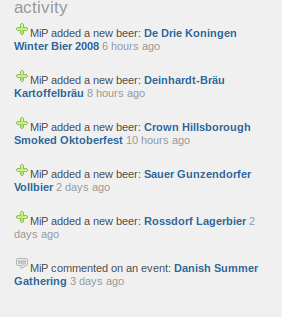

In [5]:
display_images('images/ratebeer/activity-MiP/')

## Analysis

In [3]:
%matplotlib inline

import json
from itertools import groupby
from collections import defaultdict
from datetime import date, datetime

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import numpy as np

In [4]:
SOURCE_FILE = 'data/reduced_data.txt'
# SOURCE_FILE = 'data/mobile-data.txt'
WORKING_FILE = 'data/analysis-work.json'
START_DATE = date(2008, 5, 1)
END_DATE = date(2010, 5, 1)

### Data helpers

In [5]:
def parse_json(filename, normalize=True):
    with open(filename) as f:
        for line in f:
            out = json.loads(line, encoding='latin-1')
            if normalize:
                temp = {}
                for key in out:
                    try:
                        key = clean_unicode(key)
                    except:
                        key = key
                    try:
                        temp[key] = clean_unicode(out[key])
                    except:
                        temp[key] = out[key]
                out = temp
            yield out
    f.close()

    
# via http://matplotlib.org/examples/pylab_examples/finance_work2.html
def moving_average(x, n, type='simple'):
    """
    compute an n period moving average.

    type is 'simple' | 'exponential'

    """
    x = np.asarray(x)
    if type=='simple':
        weights = np.ones(n)
    else:
        weights = np.exp(np.linspace(-1., 0., n))

    weights /= weights.sum()


    a =  np.convolve(x, weights, mode='full')[:len(x)]
    a[:n] = a[n]
    return a    

### Load reviews and group by date

In [ ]:
timestamp_keyfunc = lambda r: r.get('review/timeUnix')
date_keyfunc = lambda r: date.fromtimestamp(r.get('review/timeUnix'))

In [ ]:
reviews_iter = parse_json(SOURCE_FILE)
sorted_reviews = sorted(reviews_iter, key=timestamp_keyfunc)
with open(WORKING_FILE, 'w') as outfile:
    json.dump(sorted_reviews, outfile)

## Data

In [ ]:
def groupby_daily(sorted_reviews):
    reviews_by_date = {}
    for key, group in groupby(sorted_reviews, date_keyfunc):
        reviews_by_date[key] = len(list(group))
    return reviews_by_date

In [ ]:
reviews_by_date = groupby_daily(sorted_reviews)

In [ ]:
dates = sorted(reviews_by_date.keys())
review_counts = [reviews_by_date[k] for k in dates]

ma_days = 45
ma = moving_average(review_counts, ma_days, 'exponential')

polynomial_order = 3
trend_line = np.polyfit(range(len(dates)), review_counts, polynomial_order)

In [ ]:
print dates[0:2]
print dates[-2:]

In [ ]:
user_keyfunc = lambda r: r.get('user/profileName')

def month_keyfunc(review):
    # Return the first day of the month for any day in a month
    review_date = date.fromtimestamp(review.get('review/timeUnix'))
    return date(review_date.year, review_date.month, 1)

In [ ]:
def groupby_monthly(sorted_reviews):
    monthly_user_count = {}
    for key, group in groupby(sorted_reviews, month_keyfunc):
        user_sorted = sorted(group, key=user_keyfunc)
        monthly_user_count[key] = len(list(groupby(user_sorted, user_keyfunc)))
    return monthly_user_count

In [ ]:
monthly_user_count = groupby_monthly(sorted_reviews)
months = sorted(monthly_user_count.keys())
user_counts = [monthly_user_count[m] for m in months]

In [ ]:
beer_style_keyfunc = lambda r: r.get(u'beer/style')

In [ ]:
def groupby_styles_monthly(sorted_reviews):
    monthly_beer_count = {}
    all_styles = {}
    for key_month, group in groupby(sorted_reviews, month_keyfunc):
        style_sorted = sorted(group, key=beer_style_keyfunc)
        monthly_beer_count[key_month] = {}
        for key_style, subgroup in groupby(style_sorted, beer_style_keyfunc):
            style_count = len(list(subgroup))
            monthly_beer_count[key_month][key_style] = style_count
            all_styles[key_style] = all_styles.setdefault(key_style, 0) + style_count
    return monthly_beer_count, all_styles

In [ ]:
monthly_beer_count, all_styles = groupby_styles_monthly(sorted_reviews)

In [ ]:
N_styles = 10
top_N_styles = sorted(all_styles.items(), key=lambda s: s[1], reverse=True)[0:N_styles]
top_styles = [s[0] for s in top_N_styles]

months = sorted(monthly_beer_count.keys())
style_counts = {}

for style in top_styles:
    month_counts = []
    for month in months:
        month_counts.append(monthly_beer_count[month][style])
    style_counts[style] = month_counts
    
# Count of reviews for beers outside top_N_styles
other_counts = []
for i in range(len(months)):
    month = months[i]
    total_reviews = sum(monthly_beer_count[month].values())
    top_style_reviews = sum([style_counts[s][i] for s in top_styles])
    other_counts.insert(0, total_reviews - top_style_reviews)
style_counts['Other'] = other_counts
top_styles.insert(0, 'Other')

In [ ]:
print 'Total reviews: %s' % "{:,}".format(len(sorted_reviews))
print

In [ ]:
# IPython gets really angry if we don't release the big sorted collection. Cya later!
sorted_reviews = None

In [ ]:
# Provides access to sorted_reviews if necessary
def sorted_reviews_iter():
    decoder = json.JSONDecoder()
    with open(WORKING_FILE) as infile:
        for line in infile:
            yield decoder.decode(line.strip())

### Plot of total RateBeer reviews between November 1, 2008 and November 1, 2009

In [ ]:
current_palette = sns.color_palette("Paired", 10)

In [ ]:
def plot_reviews(dates, review_counts, ma, ma_days, trend_line, polynomial_order, current_palette):

    fig, axes = plt.subplots(1, figsize=(16, 10))

    # Review count plot
    axes.plot(dates, review_counts, color=current_palette[1], lw=1, label='Daily reviews')
    axes.fill_between(dates, 0, review_counts, facecolor=current_palette[0], alpha=0.8)
    # Review count plot
    axes.plot(dates, ma, color=current_palette[3], lw=4, alpha=0.75, label=('%d day moving avg.' % ma_days))
    # N order linear model plot
    axes.plot(dates, np.polyval(trend_line, range(len(dates))), color=current_palette[5], lw=4, alpha=0.75, label=('Order %d linear model' % polynomial_order))

    # Labels and axes formatting
    axes.set_title('RateBeer Reviews by Date')
    axes.set_xlabel('Dates')
    axes.set_ylabel('Reviews')
    fig.autofmt_xdate()
    axes.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
    handles, labels = axes.get_legend_handles_labels()
    axes.legend(handles, labels)

    plt.show()

In [ ]:
plot_reviews(dates, review_counts, ma, ma_days, trend_line, polynomial_order, current_palette)

### Stuff

In [ ]:
def plot_users_monthly(months, user_counts, current_palette):
    fig, axes = plt.subplots(1, figsize=(16, 10))

    axes.plot(months, user_counts, color=current_palette[3], lw=1, label='Unique users')
    axes.fill_between(months, 0, user_counts, facecolor=current_palette[2], alpha=0.8)

    fig.autofmt_xdate()
    axes.set_title('RateBeer Unique Users by Month')
    axes.set_xlabel('Months')
    axes.set_ylabel('Users')
    axes.fmt_xdata = mdates.DateFormatter('%Y-%m')
    plt.show()

In [ ]:
plot_users_monthly(months, user_counts, current_palette)

In [ ]:
users_html = ["""<table>
<tr>
<th>Date</th>
<th>User Counts</th>
</tr>"""]
for i in range(len(months)):
    users_html.append("""<tr><td>%s</td><td>%s</td></tr>""" % (months[i], "{:,}".format(user_counts[i])))
users_html.append("""</table>""")

h = HTML(''.join(users_html)); h

In [ ]:
current_palette = sns.color_palette("hls", len(top_styles))

In [ ]:
def plot_styles_monthly(months, style_counts, current_palette):
    fig, axes = plt.subplots(1, figsize=(16, 10))

    area_bottoms = [0 for i in range(len(months))]
    cp_index = 0
    for style in top_styles:
        area_tops = [style_counts[style][j] + area_bottoms[j] for j in range(len(months))]

        axes.plot(months, area_tops, color=current_palette[cp_index], lw=1, label=('%s' % style))
        axes.fill_between(months, area_bottoms, area_tops, facecolor=current_palette[cp_index], alpha=0.8)

        area_bottoms = list(area_tops)
        cp_index += 1


    axes.set_title('RateBeer Style Reviews by Date')
    axes.set_xlabel('Dates')
    axes.set_ylabel('Reviews')
    fig.autofmt_xdate()
    axes.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
    handles, labels = axes.get_legend_handles_labels()
    axes.legend(handles, labels, loc=8, ncol=2, frameon=True, markerscale=5.0, fontsize='large', title='Beer Styles')

    plt.show()

In [ ]:
plot_styles_monthly(months, style_counts, current_palette)

In [ ]:
styles_html = ['<table><tr>']
styles_html.append('<th></th>')  # Blank upper left corner
for month in months:
    styles_html.append(
        ('<th>%s</th>' % month.strftime('%b %Y'))
    )
styles_html.append('</tr>')

for style in top_styles:
    styles_html.append(('<tr><td>%s</td>' % style))
    for i in range(len(months)):
        styles_html.append(('<td>%s</td>' % ('{:,}'.format(style_counts[style][i]))))
    styles_html.append('</tr>')

h = HTML(''.join(styles_html)); h